<>:150: SyntaxWarning: invalid escape sequence '\$'
<>:150: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_181312/3196528359.py:150: SyntaxWarning: invalid escape sequence '\$'
  df_selected['price'] = df_selected['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
/home/ashot/.asdf/installs/python/3.12.0/lib/python3.12/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/ashot/.asdf/installs/python/3.12.0/lib/python3.12/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) in

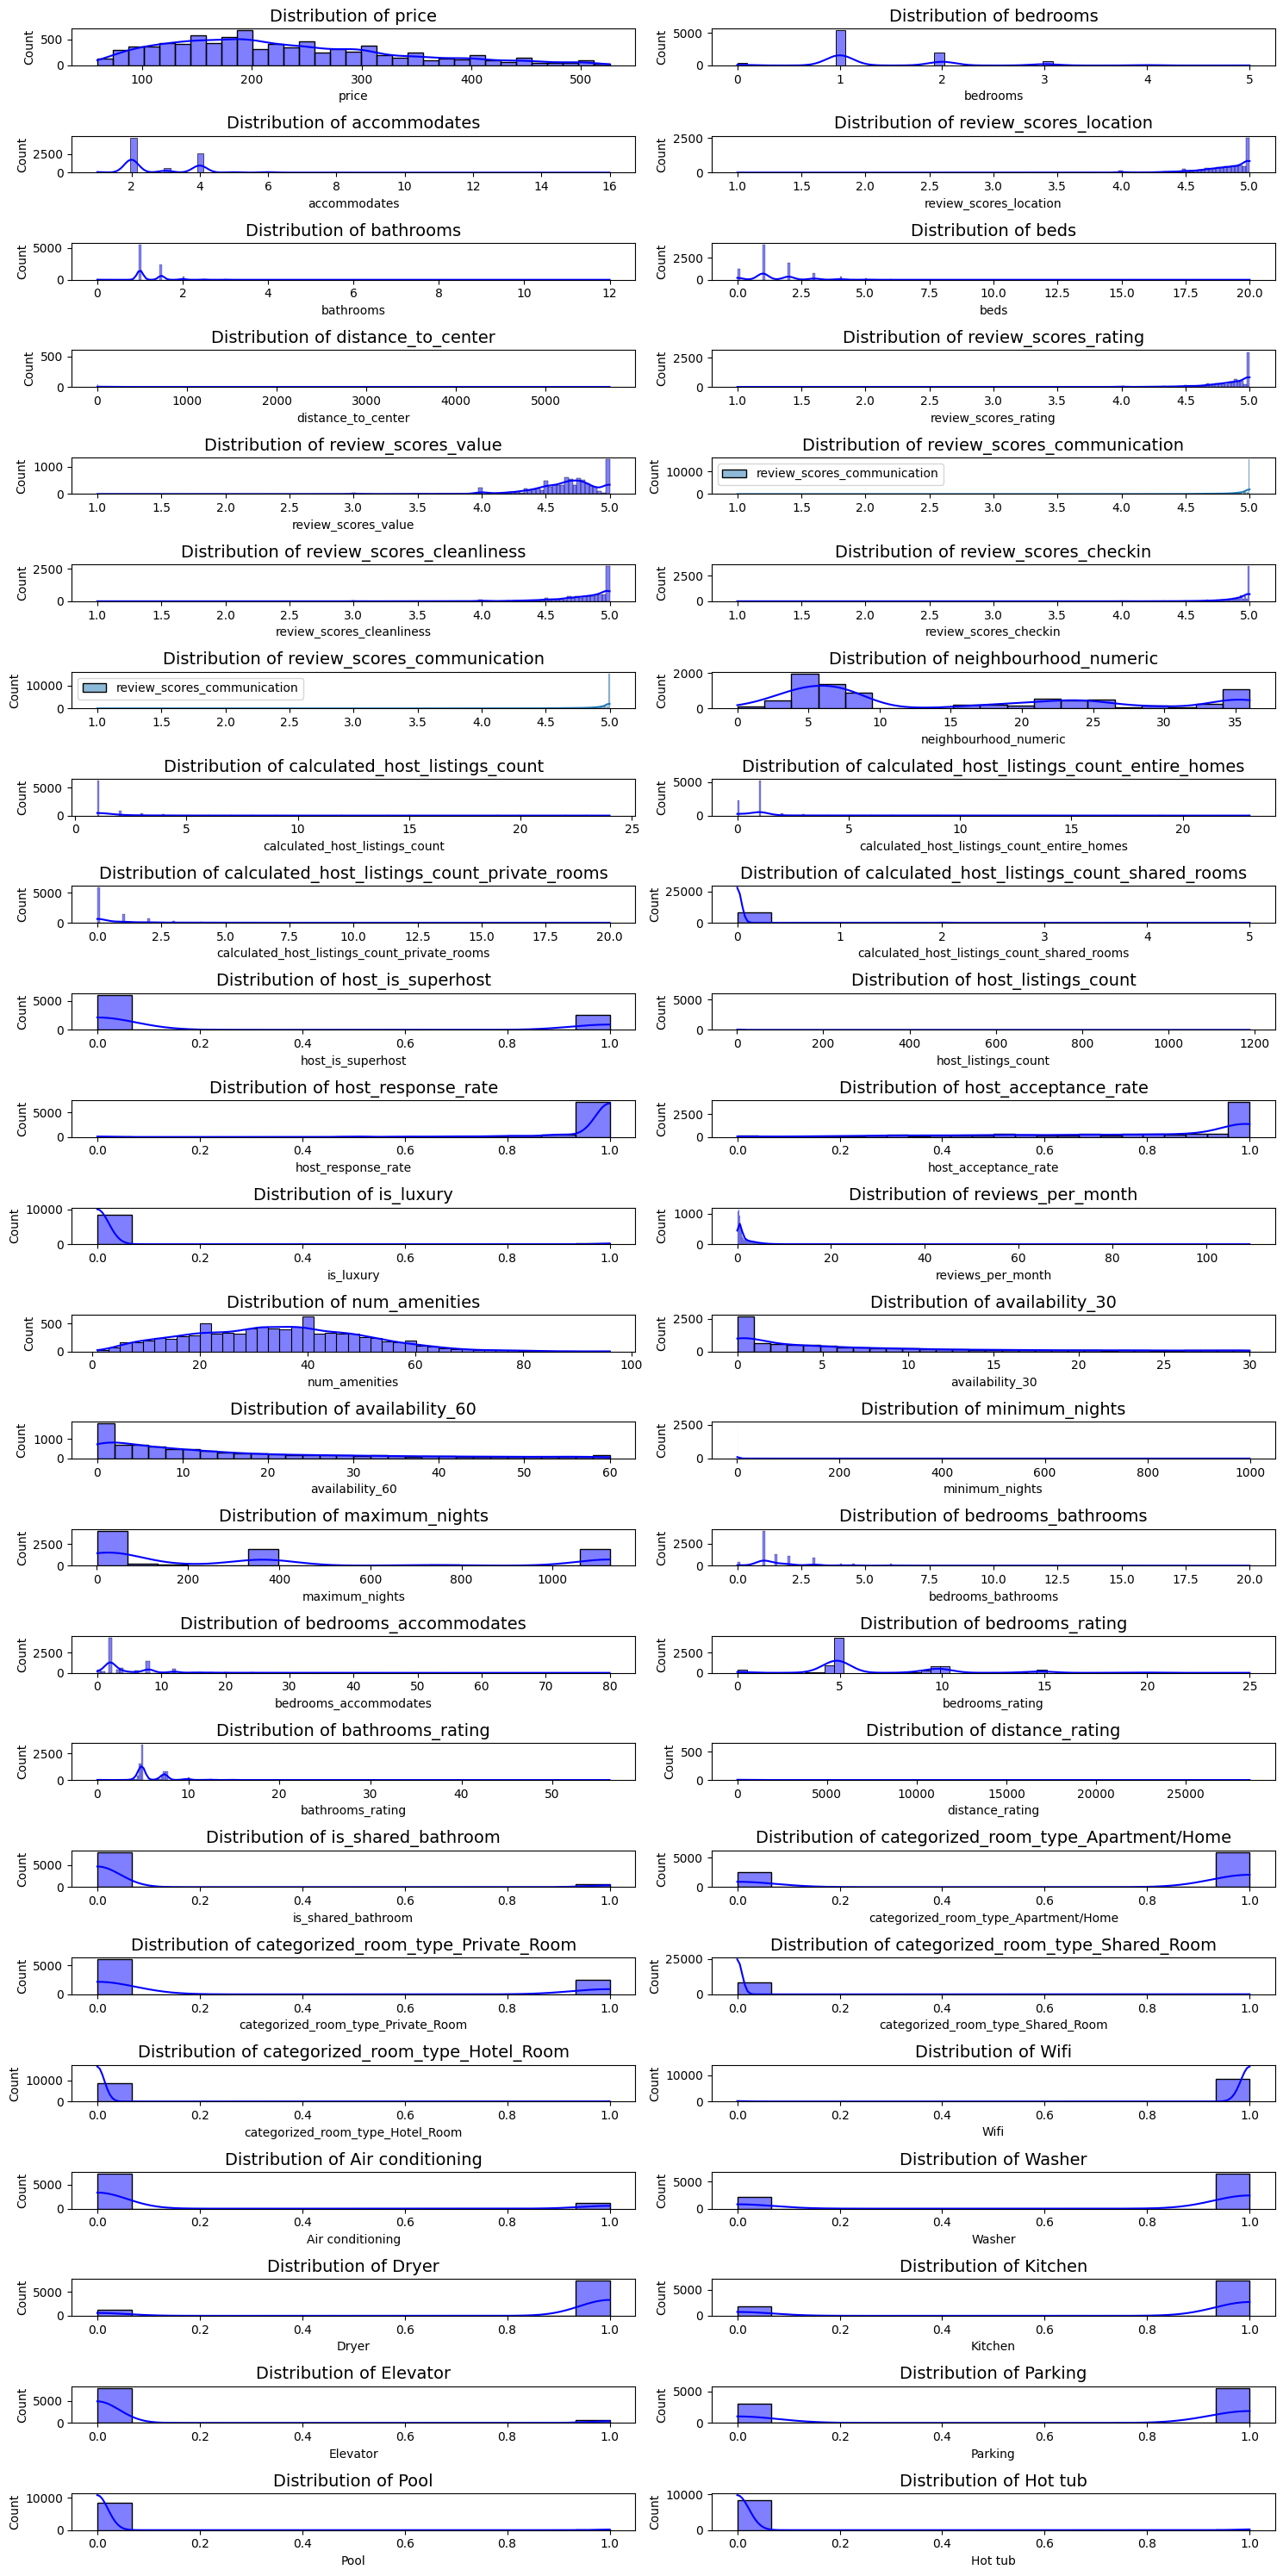

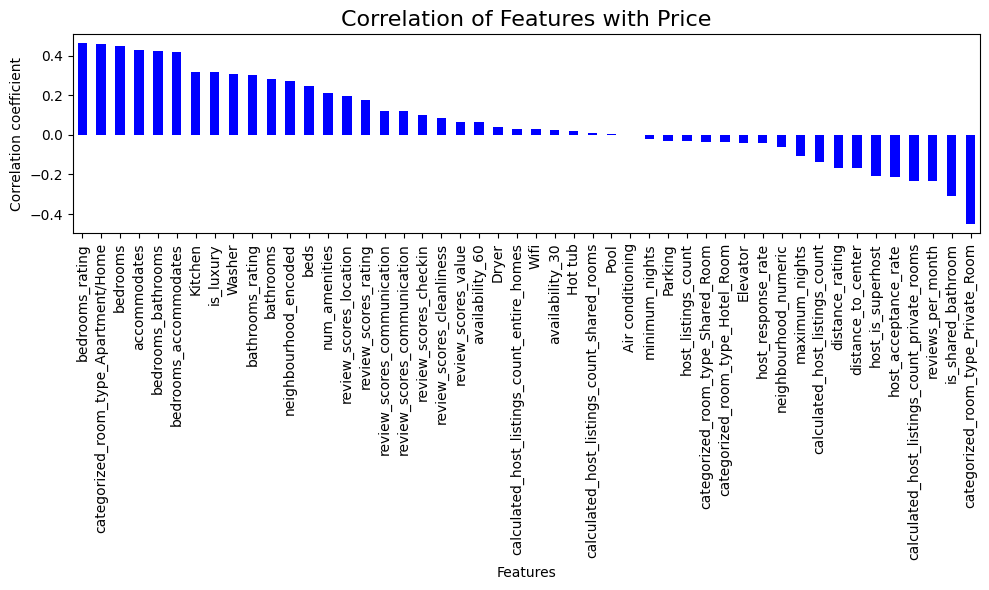

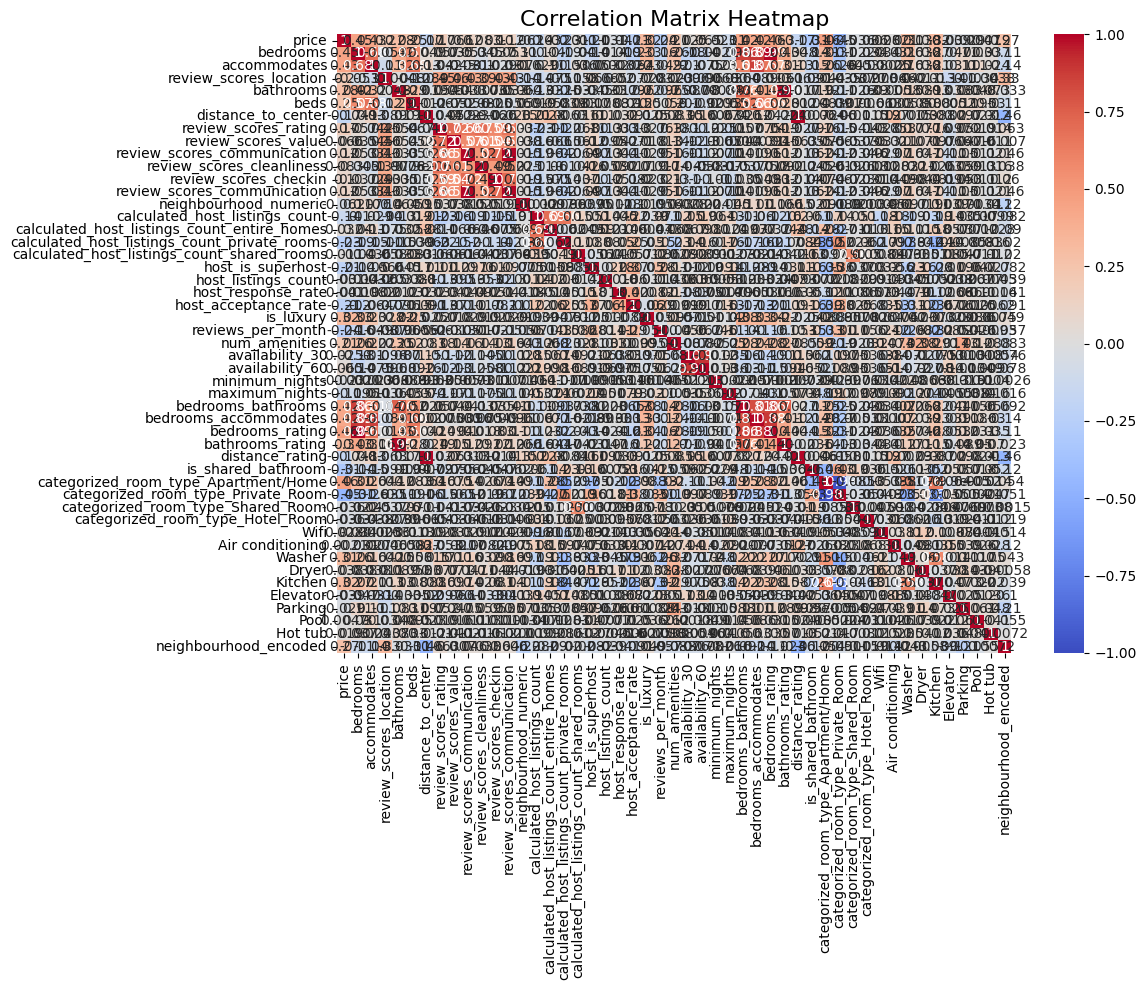

[I 2024-09-27 14:44:24,375] A new study created in memory with name: no-name-0c44f23b-1273-4967-a0f3-49f163998774


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from xgboost import XGBRegressor
import optuna
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
df = pd.read_csv('~/Desktop/03_September_2023.csv')
df2 = pd.read_csv('~/Desktop/12_December_2023.csv')
df3 = pd.read_csv('~/Desktop/11_March_2024.csv')
df4 = pd.read_csv('~/Desktop/10_June_2024.csv')

# Concatenate all dataframes for different months into one
df = pd.concat([df, df2, df3, df4], axis=0)

# Convert 'neighbourhood_cleansed' to 'category' type
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')

# Now you can use .cat.codes
df['neighbourhood_numeric'] = df['neighbourhood_cleansed'].cat.codes

# Remove rows where 'bathrooms', 'bedrooms', 'price', or 'beds' are missing
df = df.dropna(subset=['bathrooms', 'bedrooms', 'price', 'beds', 'accommodates'])


# Mapping neighborhood to numeric values
df['neighbourhood_numeric'] = df['neighbourhood_cleansed'].cat.codes
# Remove rows where 'bathrooms', 'bedrooms', 'price', or 'beds' are missing
df = df.dropna(subset=['bathrooms', 'bedrooms', 'price', 'beds', 'accommodates'])


# Haversine function for distance calculation
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371  # Earth radius in kilometers
    return r * c

# City center coordinates for Amsterdam
city_center = (52.3676, 4.9041)
df['distance_to_center'] = haversine(df['latitude'], df['longitude'], city_center[0], city_center[1])

# Clean up 'price' column
df['price'] = df['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

# Step 1: Extract bathroom values from 'bathrooms_text' and check if it's shared or private
if 'bathrooms_text' in df.columns:
    df['bathroom_type'] = np.where(df['bathrooms_text'].str.contains('shared', case=False, na=False), 'shared', 'private')
    df['bathrooms'] = pd.to_numeric(df['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0], errors='coerce')
    df['bathrooms'] = df['bathrooms'].fillna(1)

# Define a function to categorize room types
def categorize_room_type(room_type):
    if 'shared' in room_type.lower():
        return 'Shared_Room'
    elif 'private' in room_type.lower():
        return 'Private_Room'
    elif 'hotel' in room_type.lower():
        return 'Hotel_Room'
    else:
        return 'Apartment/Home'

# Apply room type categorization
df['categorized_room_type'] = df['room_type'].apply(categorize_room_type)

# Add additional features: Host-related features, reviews, and availability
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['host_listings_count'] = df['host_listings_count'].fillna(1)
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float) / 100

# One-hot encode 'property_type'
df = pd.get_dummies(df, columns=['property_type'], drop_first=True)

# Step 2: One-hot encode 'room_type' and keep 'bathroom_type' as a binary variable
df['is_shared_bathroom'] = np.where(df['bathroom_type'] == 'shared', 1, 0)

# Step 3: Drop unnecessary columns
df.drop(columns=['bathrooms_text'], errors='ignore', inplace=True)

# Remove extreme price values
price_upper_limit = df['price'].quantile(0.98)
df = df[df['price'] <= price_upper_limit]

# === Feature Engineering ===
df['bedrooms_bathrooms'] = df['bedrooms'] * df['bathrooms']
df['bedrooms_accommodates'] = df['bedrooms'] * df['accommodates']

# Add interaction features
df['bedrooms_rating'] = df['bedrooms'] * df['review_scores_rating']
df['bathrooms_rating'] = df['bathrooms'] * df['review_scores_rating']
df['distance_rating'] = df['distance_to_center'] * df['review_scores_location']

# Luxury classification based on price
luxury_threshold = df['price'].quantile(0.9)
df['is_luxury'] = np.where((df['price'] > luxury_threshold) & (df['bedrooms'] >= 3), 1, 0)

# Extract key amenities-related features
key_amenities = ['Wifi', 'Air conditioning', 'Washer', 'Dryer', 'Kitchen', 'Elevator', 'Parking', 'Pool', 'Hot tub']
df['num_amenities'] = df['amenities'].str.split(',').apply(len)

# Create binary features for key amenities
for amenity in key_amenities:
    df[amenity] = df['amenities'].str.contains(amenity, case=False, na=False).astype(int)

# Use Isolation Forest for advanced outlier detection
iso_forest = IsolationForest(contamination=0.05)
df['outliers'] = iso_forest.fit_predict(df[['price']])
df = df[df['outliers'] != -1]  # Remove outliers

# Drop irrelevant columns
irrelevant_cols = ['id', 'listing_url', 'description', 'neighborhood_overview', 'amenities', 'outliers']
df.drop(columns=irrelevant_cols, errors='ignore', inplace=True)

# Ensure 'categorized_room_type' is one-hot encoded
df = pd.get_dummies(df, columns=['categorized_room_type'], drop_first=False)


# Define the final numerical columns including all room types
numerical_cols = [
    'price', 'bedrooms', 'accommodates', 'review_scores_location', 'bathrooms', 'beds', 'distance_to_center',
    'review_scores_rating', 'review_scores_value', 'review_scores_communication', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'neighbourhood_numeric',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'host_is_superhost', 'host_listings_count', 'host_response_rate', 'host_acceptance_rate',
    'is_luxury', 'reviews_per_month', 'num_amenities', 'availability_30', 'availability_60', 'minimum_nights', 'maximum_nights',
    'bedrooms_bathrooms', 'bedrooms_accommodates', 'bedrooms_rating', 'bathrooms_rating', 'distance_rating',
    'is_shared_bathroom',
    'categorized_room_type_Apartment/Home', 'categorized_room_type_Private_Room', 'categorized_room_type_Shared_Room', 'categorized_room_type_Hotel_Room'
] + key_amenities

# Drop rows with missing values in selected numerical columns
df_selected = df[numerical_cols].dropna()

# Clean the price column by removing '$' and ',' and converting to float
df_selected['price'] = df_selected['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Target encode 'neighbourhood_numeric'
encoder = ce.TargetEncoder(cols=['neighbourhood_numeric'])
df_selected['neighbourhood_encoded'] = encoder.fit_transform(df_selected['neighbourhood_numeric'], df_selected['price'])

# Generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# We exclude 'price' and 'neighbourhood_numeric' when creating the polynomial features
X_poly = poly.fit_transform(df_selected.drop(columns=['price', 'neighbourhood_numeric']))

# Set X (independent variables) and y (dependent variable) - the actual prices
X = df_selected.drop(columns=['price', 'neighbourhood_numeric'])
y = df_selected['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.20, random_state=22)

# Visualize the distributions of key variables
fig, axes = plt.subplots(nrows=int(np.ceil(len(numerical_cols)/2)), ncols=2, figsize=(15, 30))
axes = axes.flatten()
for i, feature in enumerate(numerical_cols):
    sns.histplot(df_selected[feature], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
plt.tight_layout()
plt.show()

# Implement sample weighting for low-priced rooms
low_price_threshold = df['price'].quantile(0.33)  # Bottom third as low-price
low_price_weight = np.where(y_train <= low_price_threshold, 2, 1)
# Step 1: Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Step 2: Extract correlations with 'price'
corr_with_price = correlation_matrix['price'].drop('price')  # Drop self-correlation

# Step 3: Plot the correlation with price (Bar Plot)
plt.figure(figsize=(10, 6))
corr_with_price.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Correlation of Features with Price', fontsize=16)
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 4: Plot the heatmap for the full correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Optuna for XGBoost optimization with early stopping
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0)
    }
    model = XGBRegressor(**param, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train, sample_weight=low_price_weight, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Perform Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Train final model with best parameters
best_xgb_model = XGBRegressor(**study.best_params, random_state=22, n_jobs=-1)
best_xgb_model.fit(X_train, y_train, sample_weight=low_price_weight)

# Cross-validation for XGBoostF
cv_scores_xgb = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"XGBoost Cross-validation MSE: {-np.mean(cv_scores_xgb)}")

# Calculate and print MSE for XGBoost with Optuna
y_pred_xgb_optuna = best_xgb_model.predict(X_test)
mse_xgb_optuna = mean_squared_error(y_test, y_pred_xgb_optuna)
print(f"XGBoost Optuna MSE: {mse_xgb_optuna}")

# Save predictions to CSV
predictions_df_optuna = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_XGB_Optuna': y_pred_xgb_optuna
})

predictions_df_optuna.to_csv('~/Desktop/predicted_prices_xgb_optuna_blended.csv', index=False)

# Percentage correctness for each model
predictions_df_optuna['Percentage_Correct_XGB_Optuna'] = 100 - (abs(predictions_df_optuna['Actual_Price'] - predictions_df_optuna['Predicted_XGB_Optuna']) / predictions_df_optuna['Actual_Price']) * 100
